In [2]:
!pip install seaborn

Found 7 split directories

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   split_num     21 non-null     int64  
 1   set           21 non-null     object 
 2   samples       21 non-null     int64  
 3   positive_pct  21 non-null     float64
 4   features      21 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 968.0+ bytes
None

DataFrame Head:
   split_num    set  samples  positive_pct  features
0          0  train      310     46.129032        55
1          0    val      100     20.000000        55
2          0   test      115     46.086957        55
3          1  train      310     32.580645        55
4          1    val      115     46.086957        55

DataFrame Columns:
['split_num', 'set', 'samples', 'positive_pct', 'features']

DataFrame Shape:
(21, 5)

Plotting DataFrame Info:
<class 'pandas.

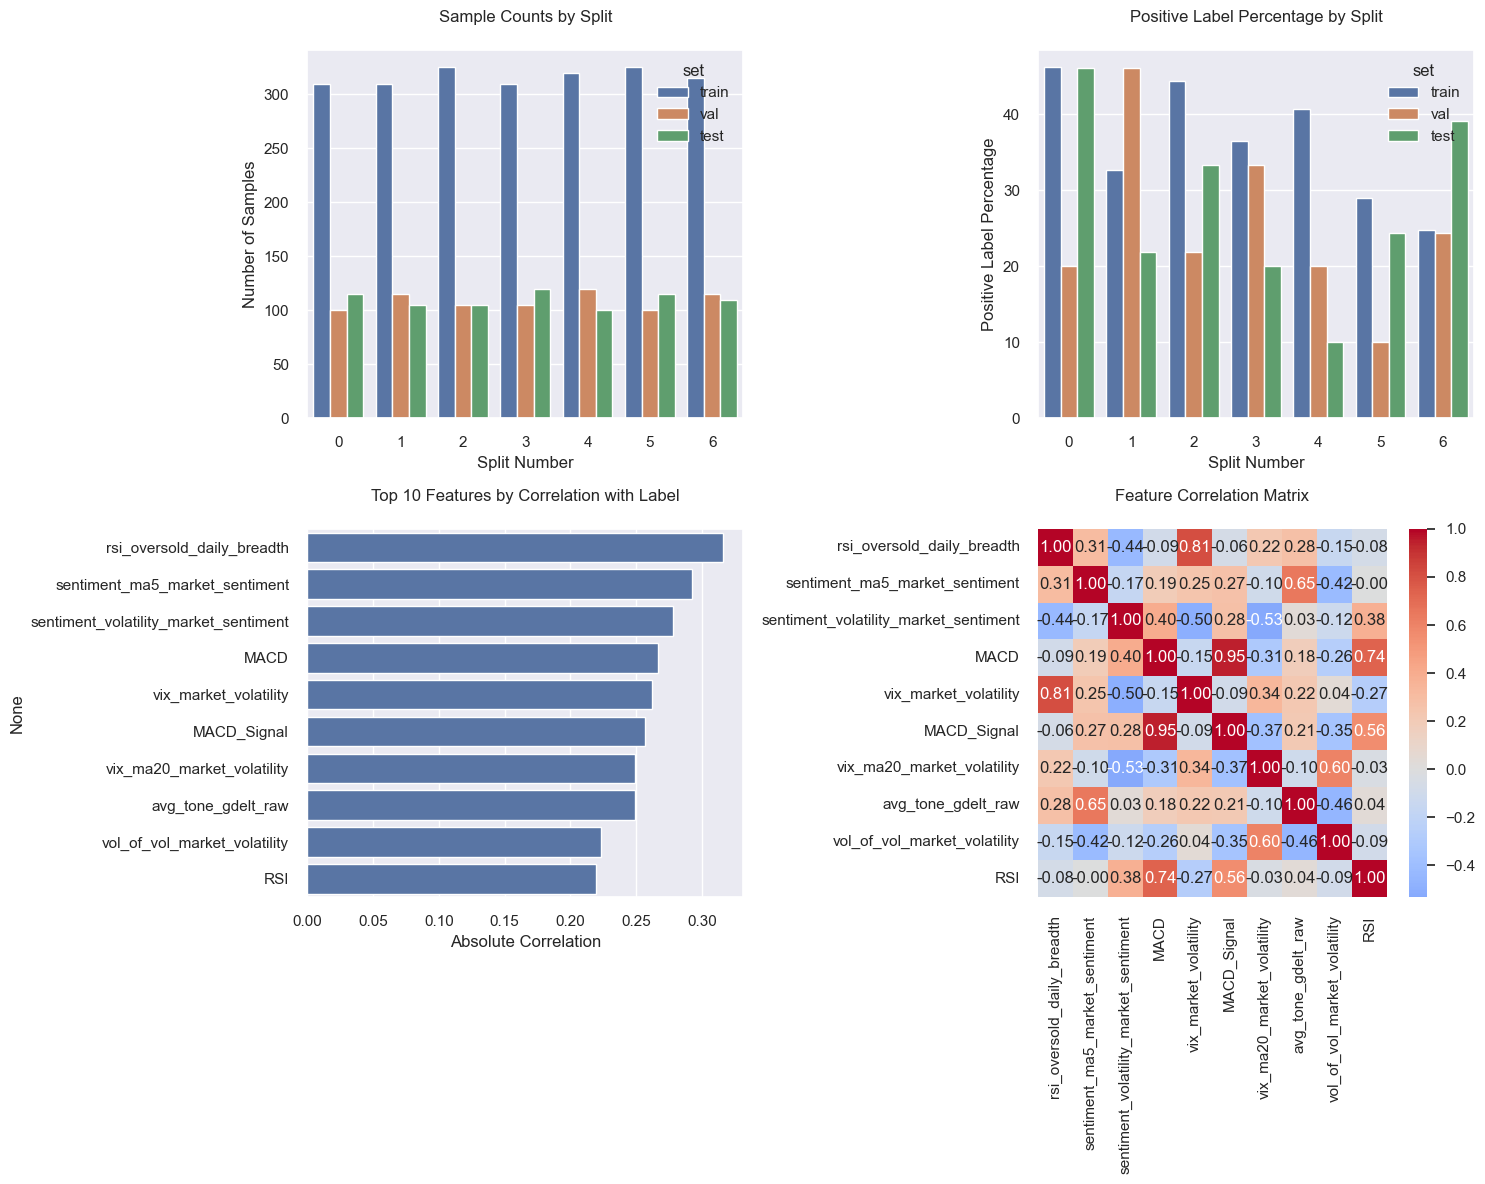


Dataset Summary:
Total splits: 7

Average samples per split:
set
test     110.00
train    316.43
val      108.57
Name: samples, dtype: float64

Label distribution range:
         min    max   mean
set                       
test   10.00  46.09  27.82
train  24.76  46.13  36.25
val    10.00  46.09  25.10


In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_theme()

def load_split(split_num):
    """Load all datasets for a given split."""
    base_path = Path('../data/ml_datasets') / f'split_{split_num}'
    return {
        'train': pd.read_parquet(base_path / 'train.parquet'),
        'val': pd.read_parquet(base_path / 'val.parquet'),
        'test': pd.read_parquet(base_path / 'test.parquet')
    }

# Load and analyze all splits
def analyze_all_splits():
    """Analyze all splits in the dataset."""
    # Get all split directories
    split_dirs = sorted(Path('../data/ml_datasets').glob('split_*'))
    
    # Check if we found any splits
    if not split_dirs:
        print("No split directories found in ../data/ml_datasets/")
        print("Current directory structure:")
        print("Contents of ../data/ml_datasets/:")
        for item in Path('../data/ml_datasets').iterdir():
            print(f"  {item.name}")
        return pd.DataFrame(columns=['split_num', 'set', 'samples', 'positive_pct', 'features'])
    
    print(f"Found {len(split_dirs)} split directories")
    
    # Initialize results storage
    split_stats = []
    
    # Analyze each split
    for split_dir in split_dirs:
        try:
            split_num = int(split_dir.name.split('_')[1])
            split_data = load_split(split_num)
            
            # Store statistics
            for name, data in split_data.items():
                stats = {
                    'split_num': split_num,
                    'set': name,
                    'samples': len(data),
                    'positive_pct': data['label'].mean() * 100,
                    'features': len(data.columns)
                }
                split_stats.append(stats)
        except Exception as e:
            print(f"Error processing split {split_dir}: {str(e)}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(split_stats)
    
    # Print detailed DataFrame information
    print("\nDataFrame Info:")
    print(df.info())
    print("\nDataFrame Head:")
    print(df.head())
    print("\nDataFrame Columns:")
    print(df.columns.tolist())
    print("\nDataFrame Shape:")
    print(df.shape)
    
    return df

# Plot split statistics
def plot_split_statistics(stats_df):
    """Plot statistics across all splits."""
    if stats_df.empty:
        print("No data to plot - DataFrame is empty")
        return None
    
    # Print DataFrame info before plotting
    print("\nPlotting DataFrame Info:")
    print(stats_df.info())
    print("\nPlotting DataFrame Head:")
    print(stats_df.head())
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Sample counts
    sns.barplot(data=stats_df, x='split_num', y='samples', hue='set', ax=axes[0,0])
    axes[0,0].set_title('Sample Counts by Split', pad=20)
    axes[0,0].set_xlabel('Split Number')
    axes[0,0].set_ylabel('Number of Samples')
    
    # Positive label percentage
    sns.barplot(data=stats_df, x='split_num', y='positive_pct', hue='set', ax=axes[0,1])
    axes[0,1].set_title('Positive Label Percentage by Split', pad=20)
    axes[0,1].set_xlabel('Split Number')
    axes[0,1].set_ylabel('Positive Label Percentage')
    
    # Feature correlations for first split
    first_split_train = load_split(0)['train']
    
    # Select only numeric columns for correlation
    numeric_cols = first_split_train.select_dtypes(include=[np.number]).columns
    correlations = first_split_train[numeric_cols].corr()['label'].abs().sort_values(ascending=False)
    top_features = correlations[1:11]  # Top 10 features
    
    sns.barplot(x=top_features.values, y=top_features.index, ax=axes[1,0])
    axes[1,0].set_title('Top 10 Features by Correlation with Label', pad=20)
    axes[1,0].set_xlabel('Absolute Correlation')
    
    # Feature correlation matrix
    sns.heatmap(first_split_train[top_features.index].corr(), 
                annot=True, cmap='coolwarm', center=0, ax=axes[1,1],
                fmt='.2f')
    axes[1,1].set_title('Feature Correlation Matrix', pad=20)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Run analysis
stats_df = analyze_all_splits()
if not stats_df.empty:
    plot_split_statistics(stats_df)
    plt.show()

    # Print summary statistics
    print("\nDataset Summary:")
    print(f"Total splits: {len(stats_df['split_num'].unique())}")
    print(f"\nAverage samples per split:")
    print(stats_df.groupby('set')['samples'].mean().round(2))
    print("\nLabel distribution range:")
    print(stats_df.groupby('set')['positive_pct'].agg(['min', 'max', 'mean']).round(2))

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path

def examine_split(split_num=0):
    """Examine the contents of a specific split in detail."""
    base_dir = Path("../data/ml_datasets")
    split_dir = base_dir / f"split_{split_num}"
    
    # Load all three datasets
    train_df = pd.read_parquet(split_dir / "train.parquet")
    val_df = pd.read_parquet(split_dir / "val.parquet")
    test_df = pd.read_parquet(split_dir / "test.parquet")
    
    print(f"\n=== Split {split_num} Overview ===")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Display feature information
    print("\n=== Feature Information ===")
    print(f"Total features: {len(train_df.columns)}")
    print("\nFeature types:")
    print(train_df.dtypes.value_counts())
    
    # Display a sample row with all its features
    print("\n=== Sample Row (First row from training set) ===")
    sample_row = train_df.iloc[0]
    print("\nBasic Information:")
    print(f"Ticker: {sample_row['ticker']}")
    print(f"Label: {sample_row['label']}")
    
    print("\nFeature Values:")
    # Format the output to be more readable
    for col in train_df.columns:
        if col not in ['ticker', 'label']:
            value = sample_row[col]
            if isinstance(value, (int, float)):
                print(f"{col}: {value:.4f}")
            else:
                print(f"{col}: {value}")
    
    # Display label distribution
    print("\n=== Label Distribution ===")
    for name, df in [("Training", train_df), ("Validation", val_df), ("Test", test_df)]:
        pos_pct = (df['label'] == 1).mean() * 100
        print(f"{name} set: {pos_pct:.1f}% positive labels")

# Example usage
examine_split(0)  # Examine split_0


=== Split 0 Overview ===
Training samples: 310
Validation samples: 100
Test samples: 115

=== Feature Information ===
Total features: 55

Feature types:
float64    47
int64       7
object      1
Name: count, dtype: int64

=== Sample Row (First row from training set) ===

Basic Information:
Ticker: 0
Label: 1

Feature Values:
Open: 128.6140
High: 129.2261
Low: 122.5821
Close: 123.4706
Volume: 112117500
Volume_Prev: 77034200.0000
Dividends: 0.0000
Stock Splits: 0.0000
RSI: 32.3401
MACD: -4.6486
MACD_Signal: -3.7740
MACD_Hist: -0.8746
BB_Upper: 147.5214
BB_Lower: 121.4307
BB_Middle: 134.4760
BB_Pband: 0.0782
SMA_20: 134.4760
SMA_50: 140.8360
SMA_100: 146.5693
SMA_200: 149.1533
EMA_100: 143.1985
EMA_200: 146.6077
analyst_targets: None
adv_dec_line_daily_breadth: -9
new_highs_daily_breadth: 25
new_lows_daily_breadth: 23
above_ma20_daily_breadth: 33.5341
above_ma50_daily_breadth: 27.9116
rsi_bullish_daily_breadth: 40.7631
rsi_oversold_daily_breadth: 1.6064
rsi_overbought_daily_breadth: 0.20

In [24]:
base_dir = Path("../data/ml_datasets")
train_df = pd.read_parquet(base_dir / "split_0/train.parquet")
train_df.head()

,Open,High,Low,Close,Volume,Volume_Prev,Dividends,Stock Splits,RSI,MACD,...,price,volatility,volume,returns_1d,returns_5d,returns_20d,momentum_5d,momentum_20d,label,ticker
0,128.613985,129.226052,122.582119,123.470612,112117500,77034200.0,0.0,0.0,32.340115,-4.648601,...,144.787437,121.734528,921494516,-0.004220,-0.002536,-0.073292,-0.000420,-0.003674,1,0
1,125.267339,127.014709,123.480487,124.744118,89113600,112117500.0,0.0,0.0,34.889560,-4.729344,...,146.443378,123.463856,999060433,0.011437,0.014846,-0.039615,0.003045,-0.001901,1,0
2,125.504275,126.136090,123.164587,123.421257,80962700,89113600.0,0.0,0.0,33.478399,-4.844235,...,142.558144,119.443175,918907331,-0.026531,0.001112,-0.047427,0.000374,-0.002300,1,0
3,124.398582,128.623840,123.292902,127.962410,87754700,80962700.0,0.0,0.0,42.131300,-4.516788,...,146.152059,121.652154,995409424,0.025210,0.000966,-0.021572,0.000344,-0.000946,1,0
4,128.801587,131.703994,128.229002,128.485672,70790800,87754700.0,0.0,0.0,43.050535,-4.167026,...,148.006554,123.048797,1091436186,0.012689,0.017919,-0.024738,0.003717,-0.001110,1,0
